# Problem Statement

**Background**: After the reopening of international borders post COVID-19 pandemic, number of tourists around the world is booming. Tourists appetite for travels are high after 2-year lockdown to contain the spread of the virus. Despite increase in air tickets and accommodation costs, not to mention the height of inflation, travellers are fighting for airplane seats to some of the popular destinations around the world. [One of them are Japan, who fully lifted its border restriction last April to welcome tourists ahead of Golden Week Holiday](https://www.straitstimes.com/asia/east-asia/japan-lifts-all-covid-19-border-controls-for-golden-week-holidays).

Japan is one the most popular travel destinations in Asia, most notably for its cherry blossom season, winter in the north, and famous theme parks such as disneyland and universal studios. However, high expectations are sometimes met with disappointment, especially during peak season, where waiting lines for tourist attractions could take hours.

To provide a better travel experience, we are working Japanese tourism agency to identify, given a specific month, what is the popularity of different attractions, based on reviews from a popular online travel review website, Tripadvisor. We will use Feature Sentiment Analysis to characterize every review based on waiting time for all the attactions. From this result, the agency could strategize accordingly how to divert tourists from more popular places to the lesser ones to avoid overcrowding.

**Our Goals**:
* To collect sufficient users review data from Tripadvisor through webscrapping.
* Generate sentiment measurement (score) on "crowdedness" based on those reviews. 
* Create a model to accurately predict the sentiment score for production use.
    * We will initiate with Multinomial Naive Bayes algorithm as our baseline model, and iterate through various hyperparameters to get optimum result.
    * We will then compare baseline model with Random Forest model, with consideration that more complex algorithm may be needed to accurately predict the sentiment.

# Import Library

In [1]:
# dataframe
import pandas as pd
import numpy as np

# extraction
import requests
import mechanicalsoup

# feature engineering
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re

# charting
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx

# Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# transformer
from sklearn.feature_extraction.text import CountVectorizer

from tqdm import tqdm 
import time
import random

# Data Extraction

## Establish Connection to Website

> We would like to open [TripAdvisor Japan Attraction](https://www.tripadvisor.com/Attractions-g294232-Activities-oa0-Japan.html) page as a starter.

In [ ]:
# instantiate
browser = mechanicalsoup.StatefulBrowser()

In [ ]:
main_url = 'https://www.tripadvisor.com/Attractions-g294232-Activities-oa0-Japan.html'

In [ ]:
browser.open(main_url,
                headers={"User-Agent": "Mozilla/5.0 (X11; CrOS x86_64 12871.102.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.141 Safari/537.36"})

In [ ]:
browser.url

## Extract URL from Attractions 

> * This code below should work, but there is an error in TripAdvisor webpage, i.e. href is not specified correctly at page 3.
> * Expectation: /Attractions-g294232-Activities-<ins>oa60</ins>-Japan.html 
> * Reality (error): /Attractions-g294232-Activities-<ins>oa99990</ins>-Japan.html


> Alternative code slice the url and update the page number manually, this is not ideal and will not work if the url digit change. (temporary solution)

In [ ]:
url_of_places = [] # define attraction url list

In [ ]:
# define function to extract 30 attraction url per page
def get_places_url (url):
    page_num = 0 # this is review page number in html code
    
    for i in range(10):
        browser.open(url,
                headers={"User-Agent": "Mozilla/5.0 (X11; CrOS x86_64 12871.102.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.141 Safari/537.36"}) # identify page
        
        for attraction in browser.page.find_all('div', {'class':'alPVI eNNhq PgLKC tnGGX'}): # extract attractions
            url_of_places.append('https://tripadvisor.com' + attraction.find('a')['href']) # append to attraction list
        
        page_num += 3 # define next page url substring
        
        url = main_url[:61] + str(page_num) + main_url[61:]  # update url for next page
        print(url)

In [ ]:
get_places_url (main_url)

In [ ]:
len(url_of_places)

## Zoom in into each attraction

In [ ]:
reviews = pd.DataFrame(columns = ['attraction','city','address','review']) # define reviews df
no_attraction = 1

for url in tqdm(url_of_places[:300]): #looping through 300 attractions    
    time.sleep(random.randint(2,4))
    aria_label = 1 # this is review page number in html code, applicable to all attractions
    
    for i in range(10): #looping through 10 pages of comments
        try:
            browser.open(url,headers={"User-Agent": "Mozilla/5.0 (X11; CrOS x86_64 12871.102.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.141 Safari/537.36"}) # identify attraction
            
            attraction = browser.page.find('h1', {'class':'biGQs _P fiohW eIegw'}) # 1. extract attraction name
            city = browser.page.find('a', {'class':'EJavG c _S'}) # 2. extract city
            address = browser.page.find_all('button', {'class':'UikNM _G B- _S _T c G_ y wSSLS wnNQG raEkE'})[-1] # 3. extract address

            iter = 1
            for i in range(10): # loop through 10 reviews
                date = browser.page.find_all('div', {'class':'RpeCd'})[i] # 4. extract review date
                review = browser.page.find_all('span', {'class':'yCeTE'})[i+iter] # 5 extract review content
                iter +=1
                    
                # compile one row information and concat to main df
                features = pd.DataFrame (columns = ['attraction','city','address','review','date'], data = [[attraction.text,city.text,address.text,review.text,date.text]])                
                reviews = pd.concat([reviews, features]).reset_index(drop=True) 
         
            aria_label += 1
            next_page_url = browser.page.find('a', {'class':'BrOJk u j z _F wSSLS tIqAi iNBVo','aria-label':str(aria_label)})['href'] # identify url for next page
            url = 'https://www.tripadvisor.com/'+next_page_url # reassign url to new page
        except:
            aria_label += 1 # will skip to the next page

In [ ]:
reviews

In [ ]:
reviews['attraction'].unique()

In [ ]:
reviews.to_csv('../data/reviews.csv', index=False) 

# Data Cleaning

To overcome significant time resources needed for Data Extraction from the previous section, a copy of extracted is saved locally that can be imported.

In [2]:
reviews = pd.read_csv('../data/reviews.csv')

In [3]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25785 entries, 0 to 25784
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   attraction  25785 non-null  object
 1   city        25775 non-null  object
 2   address     25785 non-null  object
 3   review      25785 non-null  object
 4   date        25785 non-null  object
dtypes: object(5)
memory usage: 1007.4+ KB


In [4]:
reviews[reviews['city'].isna() == True]

,attraction,city,address,review,date
18609,Kimono Rental Asakusa Aiwafuku Shop 2,NaN,"1-11-4 Hanakawado NW Bldg. 1F, Taito 111-0033 ...",There are many options of colour and pattern o...,Dec 2019 • Family
18610,Kimono Rental Asakusa Aiwafuku Shop 2,NaN,"1-11-4 Hanakawado NW Bldg. 1F, Taito 111-0033 ...",We have booked direct with Aiwafuku shop 2 as ...,Dec 2019 • Family
18611,Kimono Rental Asakusa Aiwafuku Shop 2,NaN,"1-11-4 Hanakawado NW Bldg. 1F, Taito 111-0033 ...",地方很多人租，蠻安全的，check in 是自助式的很快很方便，附近有family mart...,Dec 2019 • Couples
18612,Kimono Rental Asakusa Aiwafuku Shop 2,NaN,"1-11-4 Hanakawado NW Bldg. 1F, Taito 111-0033 ...",We arrived at the shop a bit later in the afte...,Nov 2019 • Family
18613,Kimono Rental Asakusa Aiwafuku Shop 2,NaN,"1-11-4 Hanakawado NW Bldg. 1F, Taito 111-0033 ...",Friendly staff and very helpful. Asakusa one o...,Nov 2019 • Couples
18614,Kimono Rental Asakusa Aiwafuku Shop 2,NaN,"1-11-4 Hanakawado NW Bldg. 1F, Taito 111-0033 ...",We (a group of 10 persons) rented kimonos from...,Nov 2019 • Family
18615,Kimono Rental Asakusa Aiwafuku Shop 2,NaN,"1-11-4 Hanakawado NW Bldg. 1F, Taito 111-0033 ...","Very friendly and helpful staff, their skill a...",Nov 2019 • Couples
18616,Kimono Rental Asakusa Aiwafuku Shop 2,NaN,"1-11-4 Hanakawado NW Bldg. 1F, Taito 111-0033 ...",As someone who loves traditional clothing wear...,Nov 2019 • Solo
18617,Kimono Rental Asakusa Aiwafuku Shop 2,NaN,"1-11-4 Hanakawado NW Bldg. 1F, Taito 111-0033 ...",It is our first time trying the kimono. Overal...,Nov 2019 • Couples
18618,Kimono Rental Asakusa Aiwafuku Shop 2,NaN,"1-11-4 Hanakawado NW Bldg. 1F, Taito 111-0033 ...",First time to wear kimono and it was a great e...,Oct 2019 • Couples


> There is one attraction with empty city column. Since it is only one of 300 attractions, it will not have significant impact for the number of data that we have. These empty rows will be dropped.

In [5]:
reviews.dropna(inplace = True)

In [6]:
reviews.duplicated().value_counts()

True     13100
False    12675
dtype: int64

> ~50% of the data is duplicated. There is no pattern in the duplicated rows, suspect website display related, not code related. Decide to work with the remaining 12k data, which should be sufficient.

In [7]:
reviews = reviews.drop_duplicates(keep = 'first', ignore_index = True)

In [8]:
reviews.duplicated().value_counts()

False    12675
dtype: int64

> date column is not clean during extraction, to slice and convert to the correct datatype.

In [9]:
reviews.loc[:, 'date'] = reviews['date'].str.slice(stop=8)

In [10]:
# convert to date datatype
reviews.loc[:, 'date'] = pd.to_datetime(reviews['date'], format='%b %Y')

C:\Users\darwi\AppData\Local\Temp\ipykernel_16848\311490904.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  reviews.loc[:, 'date'] = pd.to_datetime(reviews['date'], format='%b %Y')


In [11]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12675 entries, 0 to 12674
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   attraction  12675 non-null  object        
 1   city        12675 non-null  object        
 2   address     12675 non-null  object        
 3   review      12675 non-null  object        
 4   date        12675 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 495.2+ KB


In [12]:
reviews

,attraction,city,address,review,date
0,Fushimi Inari-taisha Shrine,Kyoto,"68 Fukakusa Yabunouchicho, Fushimi-ku, Kyoto 6...",We visited Fushimi Inari as part of a tour (hi...,2020-03-01
1,Fushimi Inari-taisha Shrine,Kyoto,"68 Fukakusa Yabunouchicho, Fushimi-ku, Kyoto 6...","We loved this shrine, so amazing and a nice ea...",2020-05-01
2,Fushimi Inari-taisha Shrine,Kyoto,"68 Fukakusa Yabunouchicho, Fushimi-ku, Kyoto 6...",A trip to Kyoto is incomplete without visiting...,2019-12-01
3,Fushimi Inari-taisha Shrine,Kyoto,"68 Fukakusa Yabunouchicho, Fushimi-ku, Kyoto 6...",One of Kyoto’s oldest historic landmarks!!The ...,2021-03-01
4,Fushimi Inari-taisha Shrine,Kyoto,"68 Fukakusa Yabunouchicho, Fushimi-ku, Kyoto 6...",What you see in the pictures is just the very ...,2020-02-01
...,...,...,...,...,...
12670,Studio Escape,Osaka,"1-6-17 Shikitsunishi, Naniwa-ku, Osaka 556-001...","We stumbled upon this by accident, having take...",2018-04-01
12671,Studio Escape,Osaka,"1-6-17 Shikitsunishi, Naniwa-ku, Osaka 556-001...",This is my 70-something escape room and one of...,2019-10-01
12672,Studio Escape,Osaka,"1-6-17 Shikitsunishi, Naniwa-ku, Osaka 556-001...","A friend wanted to try this, so he organised f...",2019-08-01
12673,Studio Escape,Osaka,"1-6-17 Shikitsunishi, Naniwa-ku, Osaka 556-001...",Nice escape room. Can highly recommend. The ow...,2019-07-01


In [13]:
# Create year and month feature
reviews['year'] = reviews['date'].dt.year
reviews['month'] = reviews['date'].dt.month

In [14]:
reviews

,attraction,city,address,review,date,year,month
0,Fushimi Inari-taisha Shrine,Kyoto,"68 Fukakusa Yabunouchicho, Fushimi-ku, Kyoto 6...",We visited Fushimi Inari as part of a tour (hi...,2020-03-01,2020,3
1,Fushimi Inari-taisha Shrine,Kyoto,"68 Fukakusa Yabunouchicho, Fushimi-ku, Kyoto 6...","We loved this shrine, so amazing and a nice ea...",2020-05-01,2020,5
2,Fushimi Inari-taisha Shrine,Kyoto,"68 Fukakusa Yabunouchicho, Fushimi-ku, Kyoto 6...",A trip to Kyoto is incomplete without visiting...,2019-12-01,2019,12
3,Fushimi Inari-taisha Shrine,Kyoto,"68 Fukakusa Yabunouchicho, Fushimi-ku, Kyoto 6...",One of Kyoto’s oldest historic landmarks!!The ...,2021-03-01,2021,3
4,Fushimi Inari-taisha Shrine,Kyoto,"68 Fukakusa Yabunouchicho, Fushimi-ku, Kyoto 6...",What you see in the pictures is just the very ...,2020-02-01,2020,2
...,...,...,...,...,...,...,...
12670,Studio Escape,Osaka,"1-6-17 Shikitsunishi, Naniwa-ku, Osaka 556-001...","We stumbled upon this by accident, having take...",2018-04-01,2018,4
12671,Studio Escape,Osaka,"1-6-17 Shikitsunishi, Naniwa-ku, Osaka 556-001...",This is my 70-something escape room and one of...,2019-10-01,2019,10
12672,Studio Escape,Osaka,"1-6-17 Shikitsunishi, Naniwa-ku, Osaka 556-001...","A friend wanted to try this, so he organised f...",2019-08-01,2019,8
12673,Studio Escape,Osaka,"1-6-17 Shikitsunishi, Naniwa-ku, Osaka 556-001...",Nice escape room. Can highly recommend. The ow...,2019-07-01,2019,7


# Feature Engineering

## Tokenize, Lemmatize, Stop Words

In [15]:
# instantiate tokenizer to match word characters
tokenizer = RegexpTokenizer(r'\w+')

In [16]:
# instantiate lemmatizer to convert to base word form
lemmatizer = WordNetLemmatizer()

In [17]:
list_of_reviews = [] # to store all reviews

for i, row in tqdm (reviews.iterrows(), total = len (reviews)):
    review = row ['review']
    
    # tokenize
    review_token = tokenizer.tokenize(review.lower())

    # remove stop words
    clean_review_token = []
    for token in review_token:
        if token not in stopwords.words('english'):
            clean_review_token.append(token)
    
    # lemmatize token
    for j in range(len(clean_review_token)):
        clean_review_token[j] = lemmatizer.lemmatize(clean_review_token[j])
        
    # join back into a single string
    lemmatize_clean_review_token = ' '.join(clean_review_token)
    list_of_reviews.append(lemmatize_clean_review_token)

100%|████████████████████████████████████| 12675/12675 [04:49<00:00, 43.80it/s]


In [18]:
# merge "engineered review" into the main df 
reviews.loc[:, 'engineered_review'] = list_of_reviews

In [19]:
reviews

,attraction,city,address,review,date,year,month,engineered_review
0,Fushimi Inari-taisha Shrine,Kyoto,"68 Fukakusa Yabunouchicho, Fushimi-ku, Kyoto 6...",We visited Fushimi Inari as part of a tour (hi...,2020-03-01,2020,3,visited fushimi inari part tour highly recomme...
1,Fushimi Inari-taisha Shrine,Kyoto,"68 Fukakusa Yabunouchicho, Fushimi-ku, Kyoto 6...","We loved this shrine, so amazing and a nice ea...",2020-05-01,2020,5,loved shrine amazing nice easy hike went early...
2,Fushimi Inari-taisha Shrine,Kyoto,"68 Fukakusa Yabunouchicho, Fushimi-ku, Kyoto 6...",A trip to Kyoto is incomplete without visiting...,2019-12-01,2019,12,trip kyoto incomplete without visiting fushimi...
3,Fushimi Inari-taisha Shrine,Kyoto,"68 Fukakusa Yabunouchicho, Fushimi-ku, Kyoto 6...",One of Kyoto’s oldest historic landmarks!!The ...,2021-03-01,2021,3,one kyoto oldest historic landmark important i...
4,Fushimi Inari-taisha Shrine,Kyoto,"68 Fukakusa Yabunouchicho, Fushimi-ku, Kyoto 6...",What you see in the pictures is just the very ...,2020-02-01,2020,2,see picture surface place spend hour recommend...
...,...,...,...,...,...,...,...,...
12670,Studio Escape,Osaka,"1-6-17 Shikitsunishi, Naniwa-ku, Osaka 556-001...","We stumbled upon this by accident, having take...",2018-04-01,2018,4,stumbled upon accident taken food tour run one...
12671,Studio Escape,Osaka,"1-6-17 Shikitsunishi, Naniwa-ku, Osaka 556-001...",This is my 70-something escape room and one of...,2019-10-01,2019,10,70 something escape room one favourite theme a...
12672,Studio Escape,Osaka,"1-6-17 Shikitsunishi, Naniwa-ku, Osaka 556-001...","A friend wanted to try this, so he organised f...",2019-08-01,2019,8,friend wanted try organised three u together d...
12673,Studio Escape,Osaka,"1-6-17 Shikitsunishi, Naniwa-ku, Osaka 556-001...",Nice escape room. Can highly recommend. The ow...,2019-07-01,2019,7,nice escape room highly recommend owner nice g...


## Feature Sentiment Analysis

**Workflow:**

* Identify suitable keywords from original review column to create sentiment score.
* Check 'negated' version, preferrably <20% of total to assign sentiment correctly. Because when we engineered the review (remove stop words), we have no control over the negated portion.
* When we transform the data in the latter section, need to adjust hyperparameter (max_features, min_df, max_df) to ensure that those words are captured in order to model accurately.

### word #1 : crowd

In [20]:
# identify all reviews with 'crowd' word included
wait_list = []
for review in reviews['review']:
    if ('crowd' in review):
        wait_list.append(review)

In [21]:
print(len(wait_list))
wait_list[:10]

713


['We visited Fushimi Inari as part of a tour (highly recommend to do a tour so that you understand the stories and meanings behind each part of the shrine). This place is huge- it sits on a mountain and you can hike through the entire shrine. It was still crowded enough with locals and quite a lot of tourists despite all the virus hype, so I can’t imagine how much busier it is during normal tourist season! It is better to visit early in the morning. In one part of the shrine, there are small local stores, one of which sold boiled eggs- a must try! Delicious and boiled in the sacred waters of the shrine. Also, get ready for a major workout - if you plan to walk the entire length of it, there are many steps and lots of long, narrow trails.',
 "We loved this shrine, so amazing and a nice easy hike. We went very early in the morning to avoid any crowds, I believe we arrived around 8am & there were very few people there. Took the subway system from Kyoto Station and it's only about a block 

In [22]:
# identify all reviews with 'crowd' word AND EXCLUDE negated version
wait_list = []
for review in reviews['review']:
    if ('crowd' in review) & ('no crowd' not in review) & ('not crowded' not in review) & ('n\'t crowded' not in review)& ('not overcrowded' not in review) & ('n\'t overcrowded' not in review) & ('unovercrowded' not in review):
        wait_list.append(review)

In [23]:
print(len(wait_list))
wait_list[:10]

649


['We visited Fushimi Inari as part of a tour (highly recommend to do a tour so that you understand the stories and meanings behind each part of the shrine). This place is huge- it sits on a mountain and you can hike through the entire shrine. It was still crowded enough with locals and quite a lot of tourists despite all the virus hype, so I can’t imagine how much busier it is during normal tourist season! It is better to visit early in the morning. In one part of the shrine, there are small local stores, one of which sold boiled eggs- a must try! Delicious and boiled in the sacred waters of the shrine. Also, get ready for a major workout - if you plan to walk the entire length of it, there are many steps and lots of long, narrow trails.',
 "We loved this shrine, so amazing and a nice easy hike. We went very early in the morning to avoid any crowds, I believe we arrived around 8am & there were very few people there. Took the subway system from Kyoto Station and it's only about a block 

 There are 713 identified reviews that contains 'crowd' word, and 71 of them are actually negation of crowded. 
 > Conclusion: Since negated version is only ~10% of the total identified one, `crowd` can be used to assign sentiment.

### word #2 : queue

In [24]:
# identify all reviews with 'crowd' word included
wait_list = []
for review in reviews['review']:
    if ('queue' in review):
        wait_list.append(review)

In [25]:
print(len(wait_list))
wait_list[:10]

75


['This temple is really beautiful to look at but:- pictures make it look bigger than it is- you are paying 400 yen to literally follow a really crowded pathway, try to find a gap to take a picture and then get herded along the path to the exit.We spent more time in the entrance queue than around the temple itself.If you are in the area, then you should do it but if you need to travel and plan to get there (we had to catch 2 buses to get here), then it is not worth the fuss.',
 'Yes a spectacular building because its allshiny and gold. But. The experience spoils the whole effect. We did do as advised and get there early, before it even opened, but of  course lots of others did and the queue wrapped around the walls, so still busy and once through the gate it is a one way system around the lake to see the building.You see the temple almost straight away and frankly that first sighting spot is THE spot to take your pictures, no where else has nearly as good a view. Once you have walked pa

In [26]:
# identify all reviews with 'crowd' word AND EXCLUDE negated version
wait_list = []
for review in reviews['review']:
    if ('queue' in review) & ('no queue' not in review) & ('short queue' not in review):
        wait_list.append(review)

In [27]:
print(len(wait_list))
wait_list[:10]

72


['This temple is really beautiful to look at but:- pictures make it look bigger than it is- you are paying 400 yen to literally follow a really crowded pathway, try to find a gap to take a picture and then get herded along the path to the exit.We spent more time in the entrance queue than around the temple itself.If you are in the area, then you should do it but if you need to travel and plan to get there (we had to catch 2 buses to get here), then it is not worth the fuss.',
 'Yes a spectacular building because its allshiny and gold. But. The experience spoils the whole effect. We did do as advised and get there early, before it even opened, but of  course lots of others did and the queue wrapped around the walls, so still busy and once through the gate it is a one way system around the lake to see the building.You see the temple almost straight away and frankly that first sighting spot is THE spot to take your pictures, no where else has nearly as good a view. Once you have walked pa

 There are 75 identified reviews that contains 'queue' word, and only 3 of them are actually negation of crowded. 
 > Conclusion: Since negated version is only <5% of the total identified one, `queue` can be used to assign sentiment.

### word #3 : wait

In [28]:
# identify all reviews with 'crowd' word included
wait_list = []
for review in reviews['review']:
    if ('wait' in review):
        wait_list.append(review)

In [29]:
print(len(wait_list))
wait_list[:10]

415


['"伏見稲荷大社” or "Fushimi Inari Taisha" is the most important Shrine in Kyoto. This Shrine is dedicated to the Shinto God of Rice "Inari", constructed by Imperial Order of the Empress Genmei, who reigned during the Wado Era [708-715].Empress Genmei Ordered to enshrine 3 deities in 3 mountains on the 1st day of the Horse of the second month of 711, so it\'s believed that The God "Inari" was enshrined in that day.It\'s really famous for its thousands of vermilion Torii 「千本鳥居」lining the road up to the main Shrine.It\'s a must when visiting Kyoto! You can access from the JR Fushimi station or Keihan Fushimi Inari Station. Visit our YouTube channel [Let\'s Go Lab JP] so you don\'t miss any of our adventures! We will be giving you tips for your trip to Japan! What are you waiting for? Join Us!',
 "The swathes of orange gates really do have a stunning appearance. It's easy to see why people flock here, you might be waiting a while if you want that perfect picture without someone walking through.

In [30]:
# identify all reviews with 'crowd' word AND EXCLUDE negated version
wait_list = []
for review in reviews['review']:
    if ('wait' in review) & ('short wait' not in review) & ('no wait' not in review) & ('await' not in review):
        wait_list.append(review)

In [31]:
print(len(wait_list))
wait_list[:10]

395


['"伏見稲荷大社” or "Fushimi Inari Taisha" is the most important Shrine in Kyoto. This Shrine is dedicated to the Shinto God of Rice "Inari", constructed by Imperial Order of the Empress Genmei, who reigned during the Wado Era [708-715].Empress Genmei Ordered to enshrine 3 deities in 3 mountains on the 1st day of the Horse of the second month of 711, so it\'s believed that The God "Inari" was enshrined in that day.It\'s really famous for its thousands of vermilion Torii 「千本鳥居」lining the road up to the main Shrine.It\'s a must when visiting Kyoto! You can access from the JR Fushimi station or Keihan Fushimi Inari Station. Visit our YouTube channel [Let\'s Go Lab JP] so you don\'t miss any of our adventures! We will be giving you tips for your trip to Japan! What are you waiting for? Join Us!',
 "The swathes of orange gates really do have a stunning appearance. It's easy to see why people flock here, you might be waiting a while if you want that perfect picture without someone walking through.

 There are 415 identified reviews that contains 'wait' word, and only 395 of them are actually negation of crowded. 
 > Conclusion: Since negated version is only <5% of the total identified one, `wait` can be used to assign sentiment.

### Create `crowded` binary features

In [32]:
keywords = ['crowd','queue','wait'] # keywords for sentiment analysis

In [33]:
# define function to assign sentiment
def map_keywords(review):
    for keyword in keywords:
        if keyword in review:
            return 1
    return 0

In [34]:
reviews['crowded'] = reviews['engineered_review'].apply(map_keywords) # create new column

In [35]:
reviews.head()

,attraction,city,address,review,date,year,month,engineered_review,crowded
0,Fushimi Inari-taisha Shrine,Kyoto,"68 Fukakusa Yabunouchicho, Fushimi-ku, Kyoto 6...",We visited Fushimi Inari as part of a tour (hi...,2020-03-01,2020,3,visited fushimi inari part tour highly recomme...,1
1,Fushimi Inari-taisha Shrine,Kyoto,"68 Fukakusa Yabunouchicho, Fushimi-ku, Kyoto 6...","We loved this shrine, so amazing and a nice ea...",2020-05-01,2020,5,loved shrine amazing nice easy hike went early...,1
2,Fushimi Inari-taisha Shrine,Kyoto,"68 Fukakusa Yabunouchicho, Fushimi-ku, Kyoto 6...",A trip to Kyoto is incomplete without visiting...,2019-12-01,2019,12,trip kyoto incomplete without visiting fushimi...,0
3,Fushimi Inari-taisha Shrine,Kyoto,"68 Fukakusa Yabunouchicho, Fushimi-ku, Kyoto 6...",One of Kyoto’s oldest historic landmarks!!The ...,2021-03-01,2021,3,one kyoto oldest historic landmark important i...,1
4,Fushimi Inari-taisha Shrine,Kyoto,"68 Fukakusa Yabunouchicho, Fushimi-ku, Kyoto 6...",What you see in the pictures is just the very ...,2020-02-01,2020,2,see picture surface place spend hour recommend...,0


In [36]:
reviews['crowded'].value_counts()

0    11541
1     1134
Name: crowded, dtype: int64

> After extraction is done, observe there is data imbalance between crowded and not crowded classes. This could potentially result in inaccurate and unreliable results. Need to consider assigning class weight or resampling by generating synthetic data points technique during train-test split.

In [37]:
# export to data with sentiment score
reviews.to_csv('../data/reviews_sentimental.csv', index=False) 

## Get Coordinate using GoogleMaps Geocoding API

In [38]:
# google map API key
api_key = '#your_API_key' 

In [39]:
# google map base URL
base_url = "https://maps.googleapis.com/maps/api/geocode/json"

In [40]:
# address of all attractons
addresses = reviews['address'].unique()
addresses

array(['68 Fukakusa Yabunouchicho, Fushimi-ku, Kyoto 612-0882 Kyoto Prefecture',
       '1 Kinkakujicho, Kita-ku, Kyoto 603-8361 Kyoto Prefecture',
       '1-294 Kiyomizu, Higashiyama-ku, Kyoto 605-0862 Kyoto Prefecture',
       '1-2 Nakajima-cho, Naka-ku, Hiroshima 730-0811 Hiroshima Prefecture',
       'Chuo-ku, Dotombori, Chuo, Osaka 542-0076 Osaka Prefecture',
       '2-3-1, Asakusa, Taito 111-0032 Tokyo Prefecture',
       '11 Naito-machi, Shinjuku 160-0014 Tokyo Prefecture',
       '1-1 Yoyogi-Kamizono-cho, Shibuya 151-8857 Tokyo Prefecture',
       '1-10 Otemachi Naka-ku, Hiroshima 730-0051 Hiroshima Prefecture',
       '406-1 Zoushi-cho, Nara 630-8587 Nara Prefecture',
       '469 Zoshicho, Nara 630-8501 Nara Prefecture',
       '68 Hommachi, Himeji 670-0012 Hyogo Prefecture', 'Visit website',
       '1-1 Marunouchi, Kanazawa 920-0937 Ishikawa Prefecture',
       'Miyajima-cho, Hatsukaichi 738-8501 Hiroshima Prefecture',
       '657 Sanjusangendo Mawaricho, Higashiyama-Ku, Kyot

In [41]:
len(addresses)

233

In [42]:
# Create an empty DataFrame to store coordinates
coordinates = pd.DataFrame(columns=['address', 'latitude', 'longitude'])

for address in tqdm(addresses[:233]):
    params = {
        "address": address,
        "key": api_key
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    if data["status"] == "OK":
        location = data["results"][0]["geometry"]["location"]
        latitude = location["lat"]
        longitude = location["lng"]

        # Create a DataFrame for the current address
        address_data = pd.DataFrame({'address': [address],
                                     'latitude': [latitude],
                                     'longitude': [longitude]})

        # Concatenate the current address DataFrame with the main coordinates DataFrame
        coordinates = pd.concat([coordinates, address_data], ignore_index=True)
    else:
        print("Geocoding request for", address, "failed.")

  6%|██▎                                      | 13/233 [00:10<02:40,  1.37it/s]

Geocoding request for Visit website failed.


 13%|█████▎                                   | 30/233 [00:19<01:34,  2.15it/s]

Geocoding request for Call failed.


 49%|███████████████████▌                    | 114/233 [01:03<00:56,  2.11it/s]

Geocoding request for Email failed.


 60%|████████████████████████                | 140/233 [01:16<00:43,  2.13it/s]

Geocoding request for Contact failed.


100%|████████████████████████████████████████| 233/233 [02:04<00:00,  1.87it/s]


In [43]:
coordinates

,address,latitude,longitude
0,"68 Fukakusa Yabunouchicho, Fushimi-ku, Kyoto 6...",34.967190,135.773167
1,"1 Kinkakujicho, Kita-ku, Kyoto 603-8361 Kyoto ...",35.040070,135.729855
2,"1-294 Kiyomizu, Higashiyama-ku, Kyoto 605-0862...",34.994962,135.784334
3,"1-2 Nakajima-cho, Naka-ku, Hiroshima 730-0811 ...",34.391498,132.453553
4,"Chuo-ku, Dotombori, Chuo, Osaka 542-0076 Osaka...",34.665753,135.501036
...,...,...,...
224,"660 Izumicho, Nishinotoin Higashi-Iru ,Ebisuga...",35.015074,135.755268
225,"1-1-8 Tsunashima Nishi, Kohoku-Ku Tsunashima S...",35.536753,139.634817
226,"2-22-7 Kitaueno Estate Kitaueno 101, Koto 110-...",35.717736,139.783740
227,495-2 Sakuranocho Shin Kyogokudori Sanjo Sagar...,35.008487,135.767370


> Noticed that some of the addresses were not correctly pulled from Tripadvisor website.

In [44]:
len(coordinates['address'])

229

In [45]:
reviews[reviews['address'].apply(len) < 20]['address'].unique()

array(['Visit website', 'Call', 'Email', 'Contact'], dtype=object)

> Noticed 4 addresses with systematical error. To remove attractions with these addresses.

In [46]:
len(reviews[reviews['address'].apply(len) < 20])

2475

> 2475 entries will be removed from main df

In [47]:
reviews = reviews[reviews['address'].apply(len) > 20].reset_index(drop=True)

In [48]:
reviews = pd.merge(left = reviews,
                   right = coordinates,
                   on = 'address')

In [49]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10200 entries, 0 to 10199
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   attraction         10200 non-null  object        
 1   city               10200 non-null  object        
 2   address            10200 non-null  object        
 3   review             10200 non-null  object        
 4   date               10200 non-null  datetime64[ns]
 5   year               10200 non-null  int64         
 6   month              10200 non-null  int64         
 7   engineered_review  10200 non-null  object        
 8   crowded            10200 non-null  int64         
 9   latitude           10200 non-null  float64       
 10  longitude          10200 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 956.2+ KB


# Exploratory Data Analysis

## Review Count by Year

In [50]:
review_by_year = reviews.groupby('year')['review'].count().reset_index()
review_by_year

,year,review
0,2010,4
1,2011,62
2,2012,142
3,2013,225
4,2014,447
5,2015,755
6,2016,1055
7,2017,1191
8,2018,1595
9,2019,2212


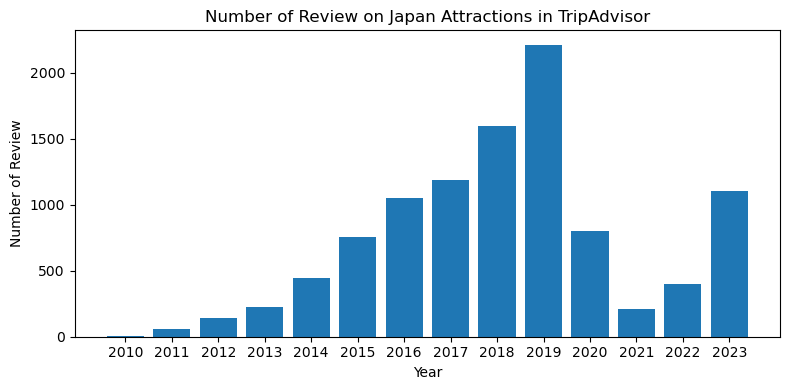

In [52]:
# Create a figure
plt.figure(figsize=(8, 4))
plt.bar(review_by_year['year'],review_by_year['review']);
plt.xlabel('Year')
plt.ylabel('Number of Review')
plt.title('Number of Review on Japan Attractions in TripAdvisor')
plt.xticks(ticks = review_by_year['year'] )
plt.tight_layout()
plt.show()

> * Because data is scraped directly from Tripadvisor website, it follows pattern where fewer reviews are extracted further into the past (2019 --> 2010)
> * However, based on chart above, fewer reviews are seen from 2020 and further down in 2022, which is highly likely due to border restriction where COVID-19 pandemic was at its peak.
> * Increasing number of reviews are seen from 2022 onwards when vaccines effectiveness was kicking in and countries are starting to welcome more tourists. 

## Review Count by Month

In [53]:
review_by_month = reviews.groupby('month')['review'].count().reset_index()
review_by_month

,month,review
0,1,859
1,2,698
2,3,880
3,4,1146
4,5,972
5,6,730
6,7,831
7,8,637
8,9,727
9,10,939


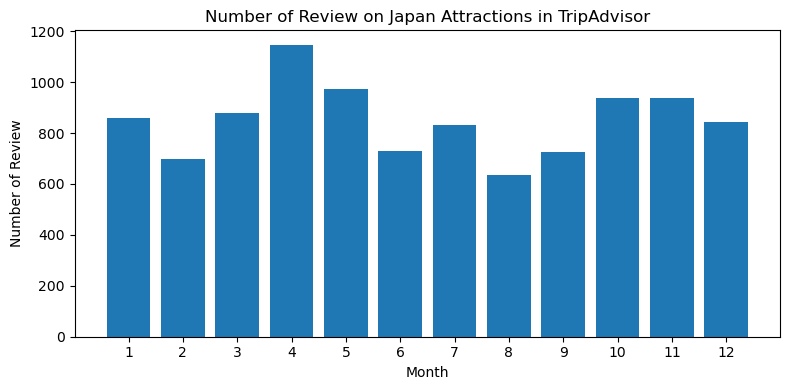

In [54]:
plt.figure(figsize=(8, 4))
plt.bar(review_by_month['month'],review_by_month['review']);
plt.xlabel('Month')
plt.ylabel('Number of Review')
plt.title('Number of Review on Japan Attractions in TripAdvisor')
plt.xticks(ticks = review_by_month['month'] )
plt.tight_layout()
plt.show()

> * Based on distribution across different months, we can see that more reviews are coming from March-May and October-January.
> * This is when Japan is famous of its cherry blossom season which is happening during spring, and end-beginning of the year is winter season which is also a popular among tourists.
> * We would also expect these months to be more crowded as more number of reviews implying more number of tourists.

## Crowdedness by Month

In [55]:
review_crowd_by_month = reviews.groupby('month')['crowded'].mean().reset_index()
review_crowd_by_month

,month,crowded
0,1,0.122235
1,2,0.073066
2,3,0.105682
3,4,0.104712
4,5,0.103909
5,6,0.065753
6,7,0.078219
7,8,0.086342
8,9,0.092160
9,10,0.105431


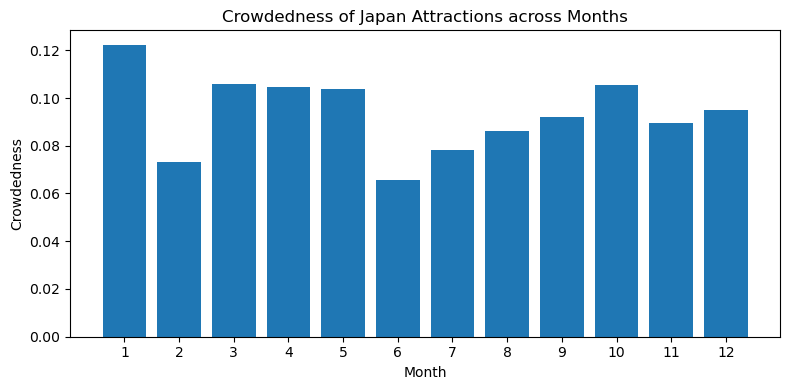

In [56]:
plt.figure(figsize=(8, 4))
plt.bar(review_crowd_by_month['month'],review_crowd_by_month['crowded']);
plt.xlabel('Month')
plt.ylabel('Crowdedness')
plt.title('Crowdedness of Japan Attractions across Months')
plt.xticks(ticks = review_crowd_by_month['month'] )
plt.tight_layout()
plt.show()

> As expected, we see similarity of crowdedness in annual trend, where spring and winter periods are most crowded.

## Crowdedness in Geomap

In [57]:
# obtain average 'crowdedness' across different locations
average_values = reviews.groupby(['latitude', 'longitude'])['crowded'].mean().reset_index()
average_values

,latitude,longitude,crowded
0,24.063168,123.779705,0.058824
1,24.326876,124.089197,0.087719
2,24.385058,123.807630,0.000000
3,24.739091,125.267034,0.250000
4,24.747343,125.417917,0.000000
...,...,...,...
221,42.918790,141.378350,0.183673
222,43.187396,140.791258,0.052632
223,43.256817,140.391944,0.102564
224,43.640709,142.849462,0.210526


In [58]:
# Load Japan's shapefile or GeoJSON
japan_boundary = gpd.read_file('../japan_map/japan_.geojson')

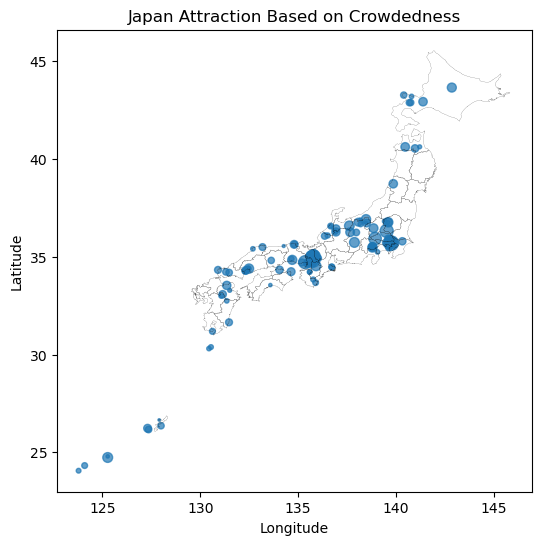

In [59]:
# Create a GeoDataFrame for average values
gdf = gpd.GeoDataFrame(average_values, geometry=gpd.points_from_xy(average_values.longitude, average_values.latitude))

# Plot the base map of Japan using geopandas
fig, ax = plt.subplots(figsize=(8,6))
japan_boundary.boundary.plot(ax=ax, color='black', linewidth=0.1)
gdf.plot(ax=ax, markersize=gdf['crowded']*200, alpha=0.7,legend=True)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Japan Attraction Based on Crowdedness')
plt.show()

> Based on the size of markers (large --> more crowded), we can see that more crowded places are distributed around central Japan, more specifically Tokyo and Kyoto.


<img src="https://www.worldatlas.com/r/w960-q80/upload/4a/5a/54/jp-01.jpg"  width="30%" >